In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import netCDF4

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data

In [4]:
sho = netCDF4.Dataset('../data/sho_friction_gl4.nc').variables
t_sho = np.array(sho['t'][:], dtype=np.float32)
s_sho = np.array(sho['s'][:], dtype=np.float32)
v_sho = np.array(sho['v'][:], dtype=np.float32)

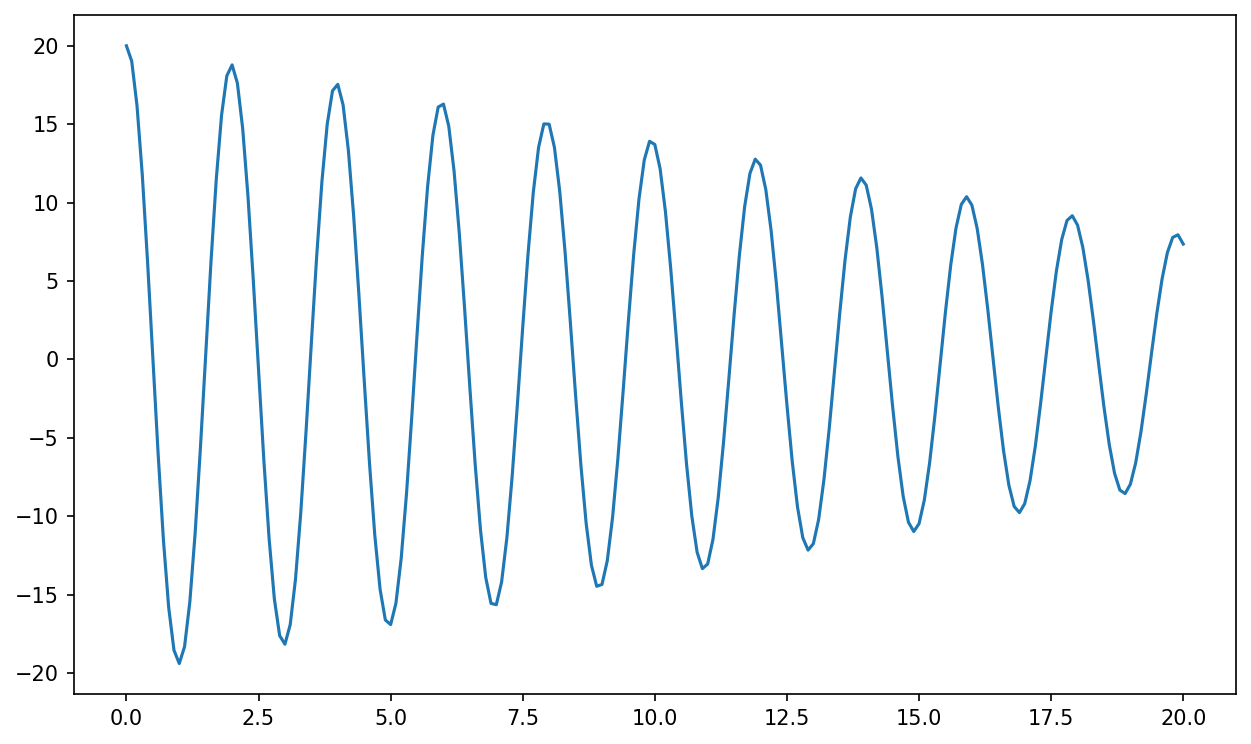

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, s_sho)
plt.show()

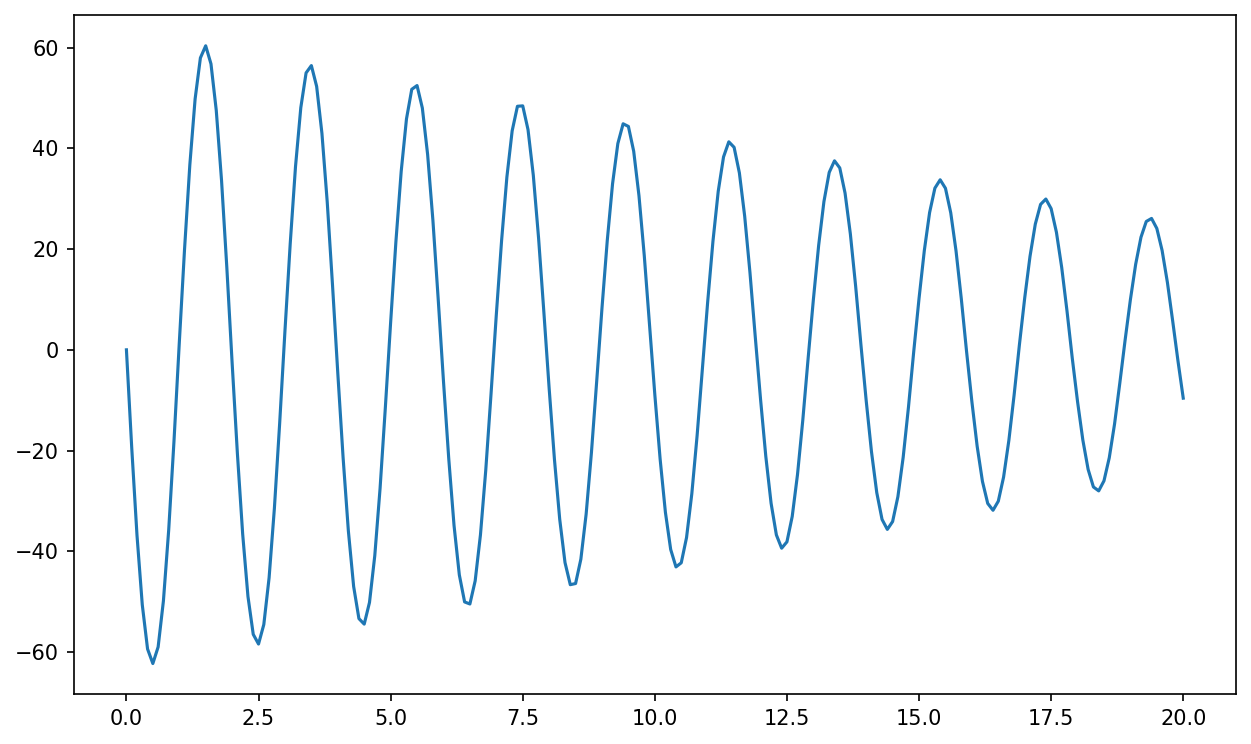

In [6]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, v_sho)
plt.show()

In [7]:
X_total = np.column_stack([s_sho, v_sho])
# X_total = s_sho.reshape(-1, 1)
sc = MinMaxScaler()
X_normalized = sc.fit_transform(X_total)

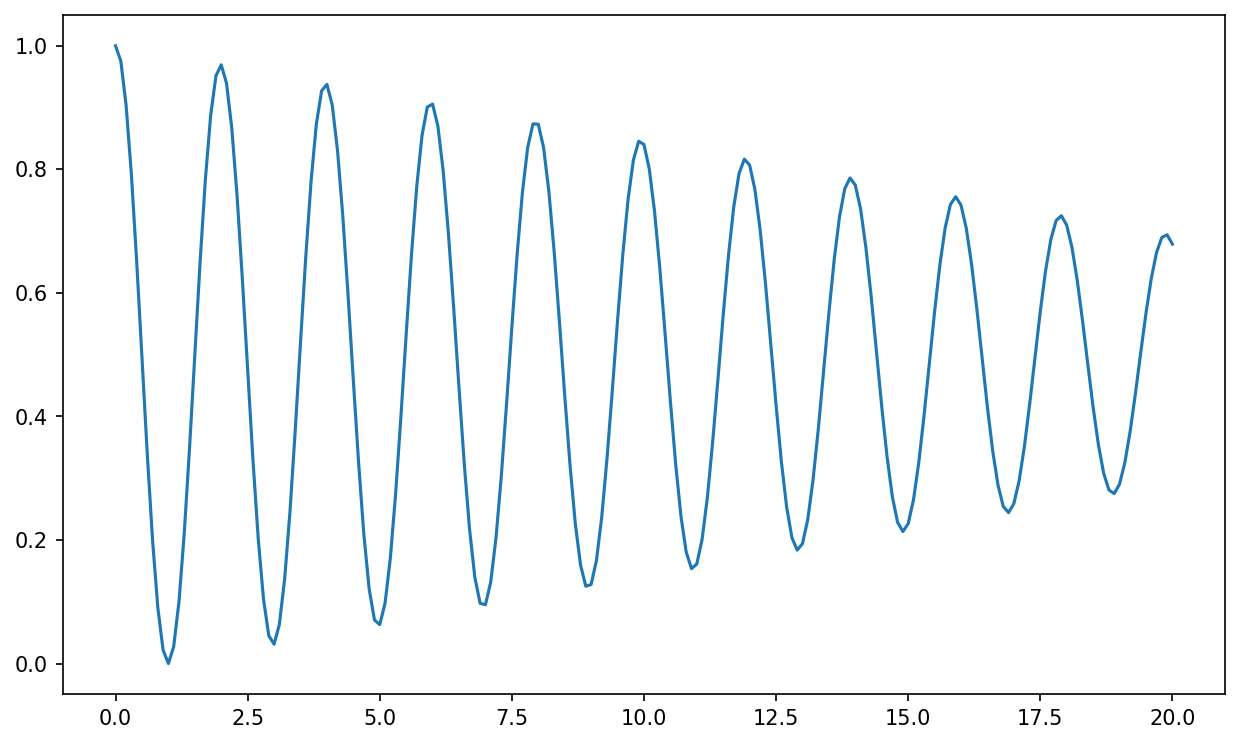

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, X_normalized[:,0])
plt.show()

In [9]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [10]:
X, y = sliding_window(X_normalized, 10)

In [11]:
X.shape

(190, 10, 2)

In [12]:
y.shape

(190, 2)

In [13]:
N = X.shape[0]
N_train = 100
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:150]
y_test = y[N_train:150]

In [14]:
class NewtonData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
ds_train = NewtonData(X_train, y_train)
ds_val = NewtonData(X_test, y_test)

In [16]:
len(ds_train)

100

In [17]:
len(ds_val)

50

In [18]:
ds_train[0][0].shape

(10, 2)

In [19]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)

In [20]:
ds_train[0]

(array([[0.99999994, 0.50784177],
        [0.97520566, 0.34990498],
        [0.90328145, 0.20763028],
        [0.79135984, 0.0951266 ],
        [0.6505398 , 0.02355051],
        [0.4947859 , 0.        ],
        [0.33954382, 0.02681047],
        [0.20020834, 0.10132325],
        [0.09059694, 0.21614915],
        [0.02157938, 0.35990125]], dtype=float32),
 array([0.        , 0.51832414], dtype=float32))

In [21]:
nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1)(torch.tensor(ds_train[0][0]).view((1, 1, -1, 2)).permute([0, 3, 2, 1]))

tensor([[[[0.5537],
          [0.5715],
          [0.5720],
          [0.5551],
          [0.5225],
          [0.4775],
          [0.4244],
          [0.3686],
          [0.3156],
          [0.2707]]]], grad_fn=<ConvolutionBackward0>)

In [22]:
class MLP(nn.Module):

    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=1),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1),
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_size)
        )
        
    def forward(self, x):
        return self.net(x.view(-1, 1, 10, 2).permute([0,3,2,1]))

In [23]:
model = MLP(input_size=10, output_size=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
model.eval()
dl_iter = iter(dl_train)
x_one, y_one = next(dl_iter)

In [25]:
x_one.shape

torch.Size([10, 10, 2])

In [26]:
x_one.view(-1,1,10,2).permute([0, 3, 2, 1]).shape

torch.Size([10, 2, 10, 1])

In [27]:
y_one.shape

torch.Size([10, 2])

In [28]:
model(x_one).shape

torch.Size([10, 2])

In [29]:
epochs = 1000
model.train()
for epoch in range(epochs+1):
    for x, y in dl_train:
        y_hat = model(x)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.07307904
epoch:  100 loss:0.00000210
epoch:  200 loss:0.00000472
epoch:  300 loss:0.00003614
epoch:  400 loss:0.00008809
epoch:  500 loss:0.00000492
epoch:  600 loss:0.00000399
epoch:  700 loss:0.00000565
epoch:  800 loss:0.00032513
epoch:  900 loss:0.00000116
epoch: 1000 loss:0.00000403


In [30]:
model.eval()

MLP(
  (net): Sequential(
    (0): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=10, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [31]:
X, y = sliding_window(X_normalized, 10)

In [32]:
total_data = NewtonData(X, y)

In [33]:
dl = DataLoader(total_data, batch_size=len(total_data))
dl_iter = iter(dl)
X, y = next(dl_iter)

In [34]:
y.shape

torch.Size([190, 2])

In [35]:
t = t_sho[10:-1]
t.shape

(190,)

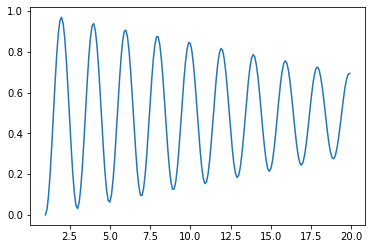

In [36]:
plt.plot(t, y[:,0].cpu().numpy())

In [37]:
y_pred = model(X)

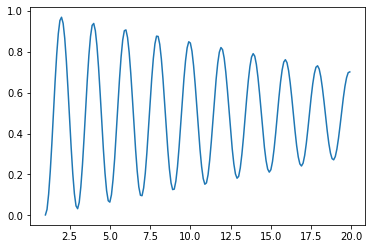

In [38]:
plt.plot(t, y_pred[:,0].detach().numpy())

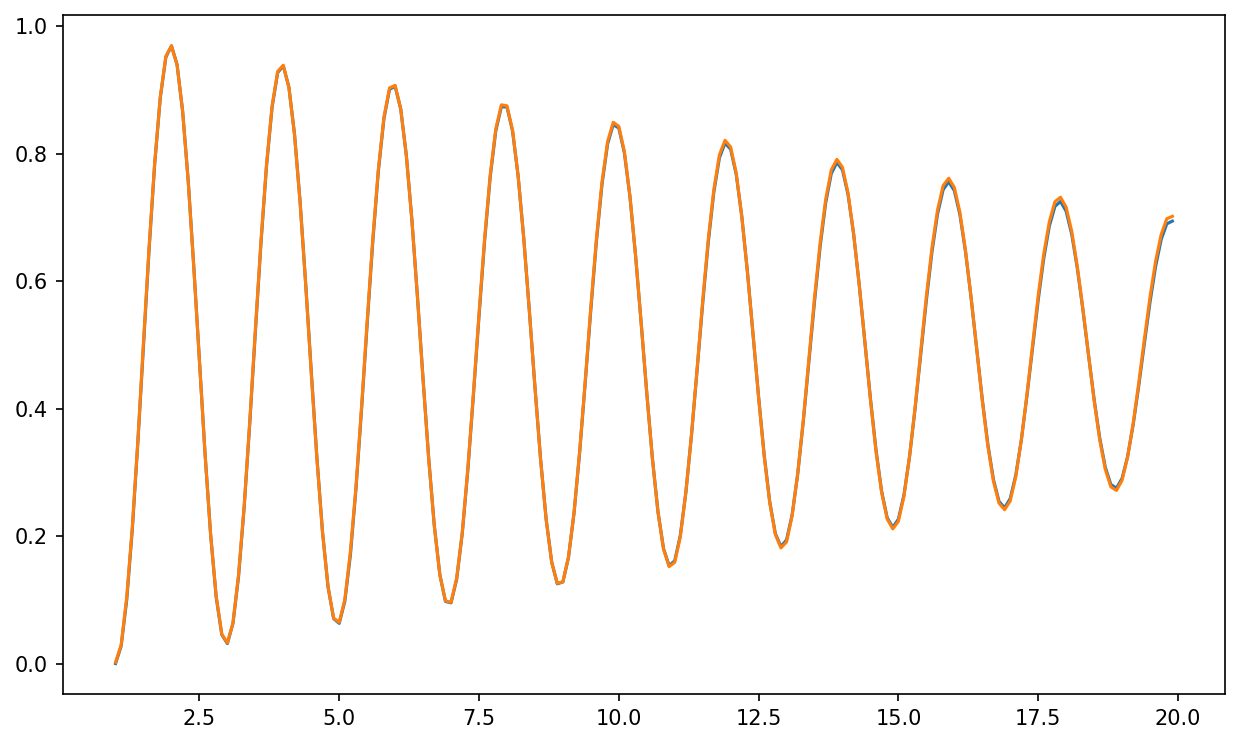

In [39]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t, y[:,0].cpu().numpy())
plt.plot(t, y_pred[:,0].detach().numpy())
plt.show()

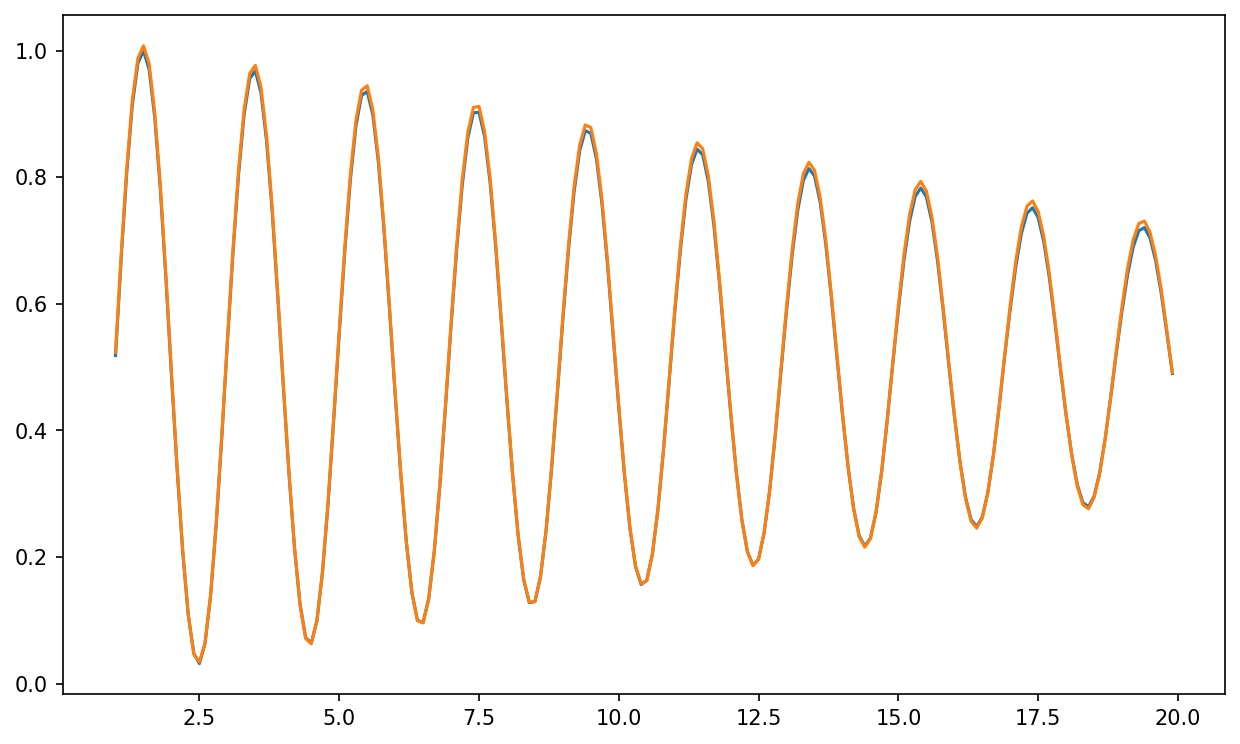

In [40]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t, y[:,1].cpu().numpy())
plt.plot(t, y_pred[:,1].detach().numpy())
plt.show()

In [41]:
X.shape

torch.Size([190, 10, 2])

In [42]:
t.shape

(190,)

In [43]:
N_extrap = 190
X_new = X[0]
X_new.shape

torch.Size([10, 2])

In [44]:
X_new.view(1,-1,2)

tensor([[[1.0000, 0.5078],
         [0.9752, 0.3499],
         [0.9033, 0.2076],
         [0.7914, 0.0951],
         [0.6505, 0.0236],
         [0.4948, 0.0000],
         [0.3395, 0.0268],
         [0.2002, 0.1013],
         [0.0906, 0.2161],
         [0.0216, 0.3599]]])

In [45]:
y_ex = []
t_ex = []
dt = 1e-1
for i in range(N_extrap):
    y_new = model(X_new.view(1, -1, 2))
    X_new = torch.concat([X_new[1:], y_new])
    t_ex.append(t[0] + i * dt)
    y_ex.append(y_new.reshape(-1, 2).detach().numpy())
y_ex = np.array(y_ex).reshape(-1, 2)

In [46]:
# t_total = np.concatenate([t[0], t_ex])
t_total = t_ex
# y_pred_total = np.concatenate([y_pred.detach().numpy()[0:100], y_ex])
y_pred_total = y_ex

In [47]:
shoo = netCDF4.Dataset('../data/sho_friction3.nc').variables
t_shoo = np.array(shoo['t'][:], dtype=np.float32)
s_shoo = np.array(shoo['s'][:], dtype=np.float32)
v_shoo = np.array(shoo['v'][:], dtype=np.float32)

In [48]:
sc = MinMaxScaler()
y_shoo_new = sc.fit_transform(np.column_stack([s_shoo, v_shoo]))

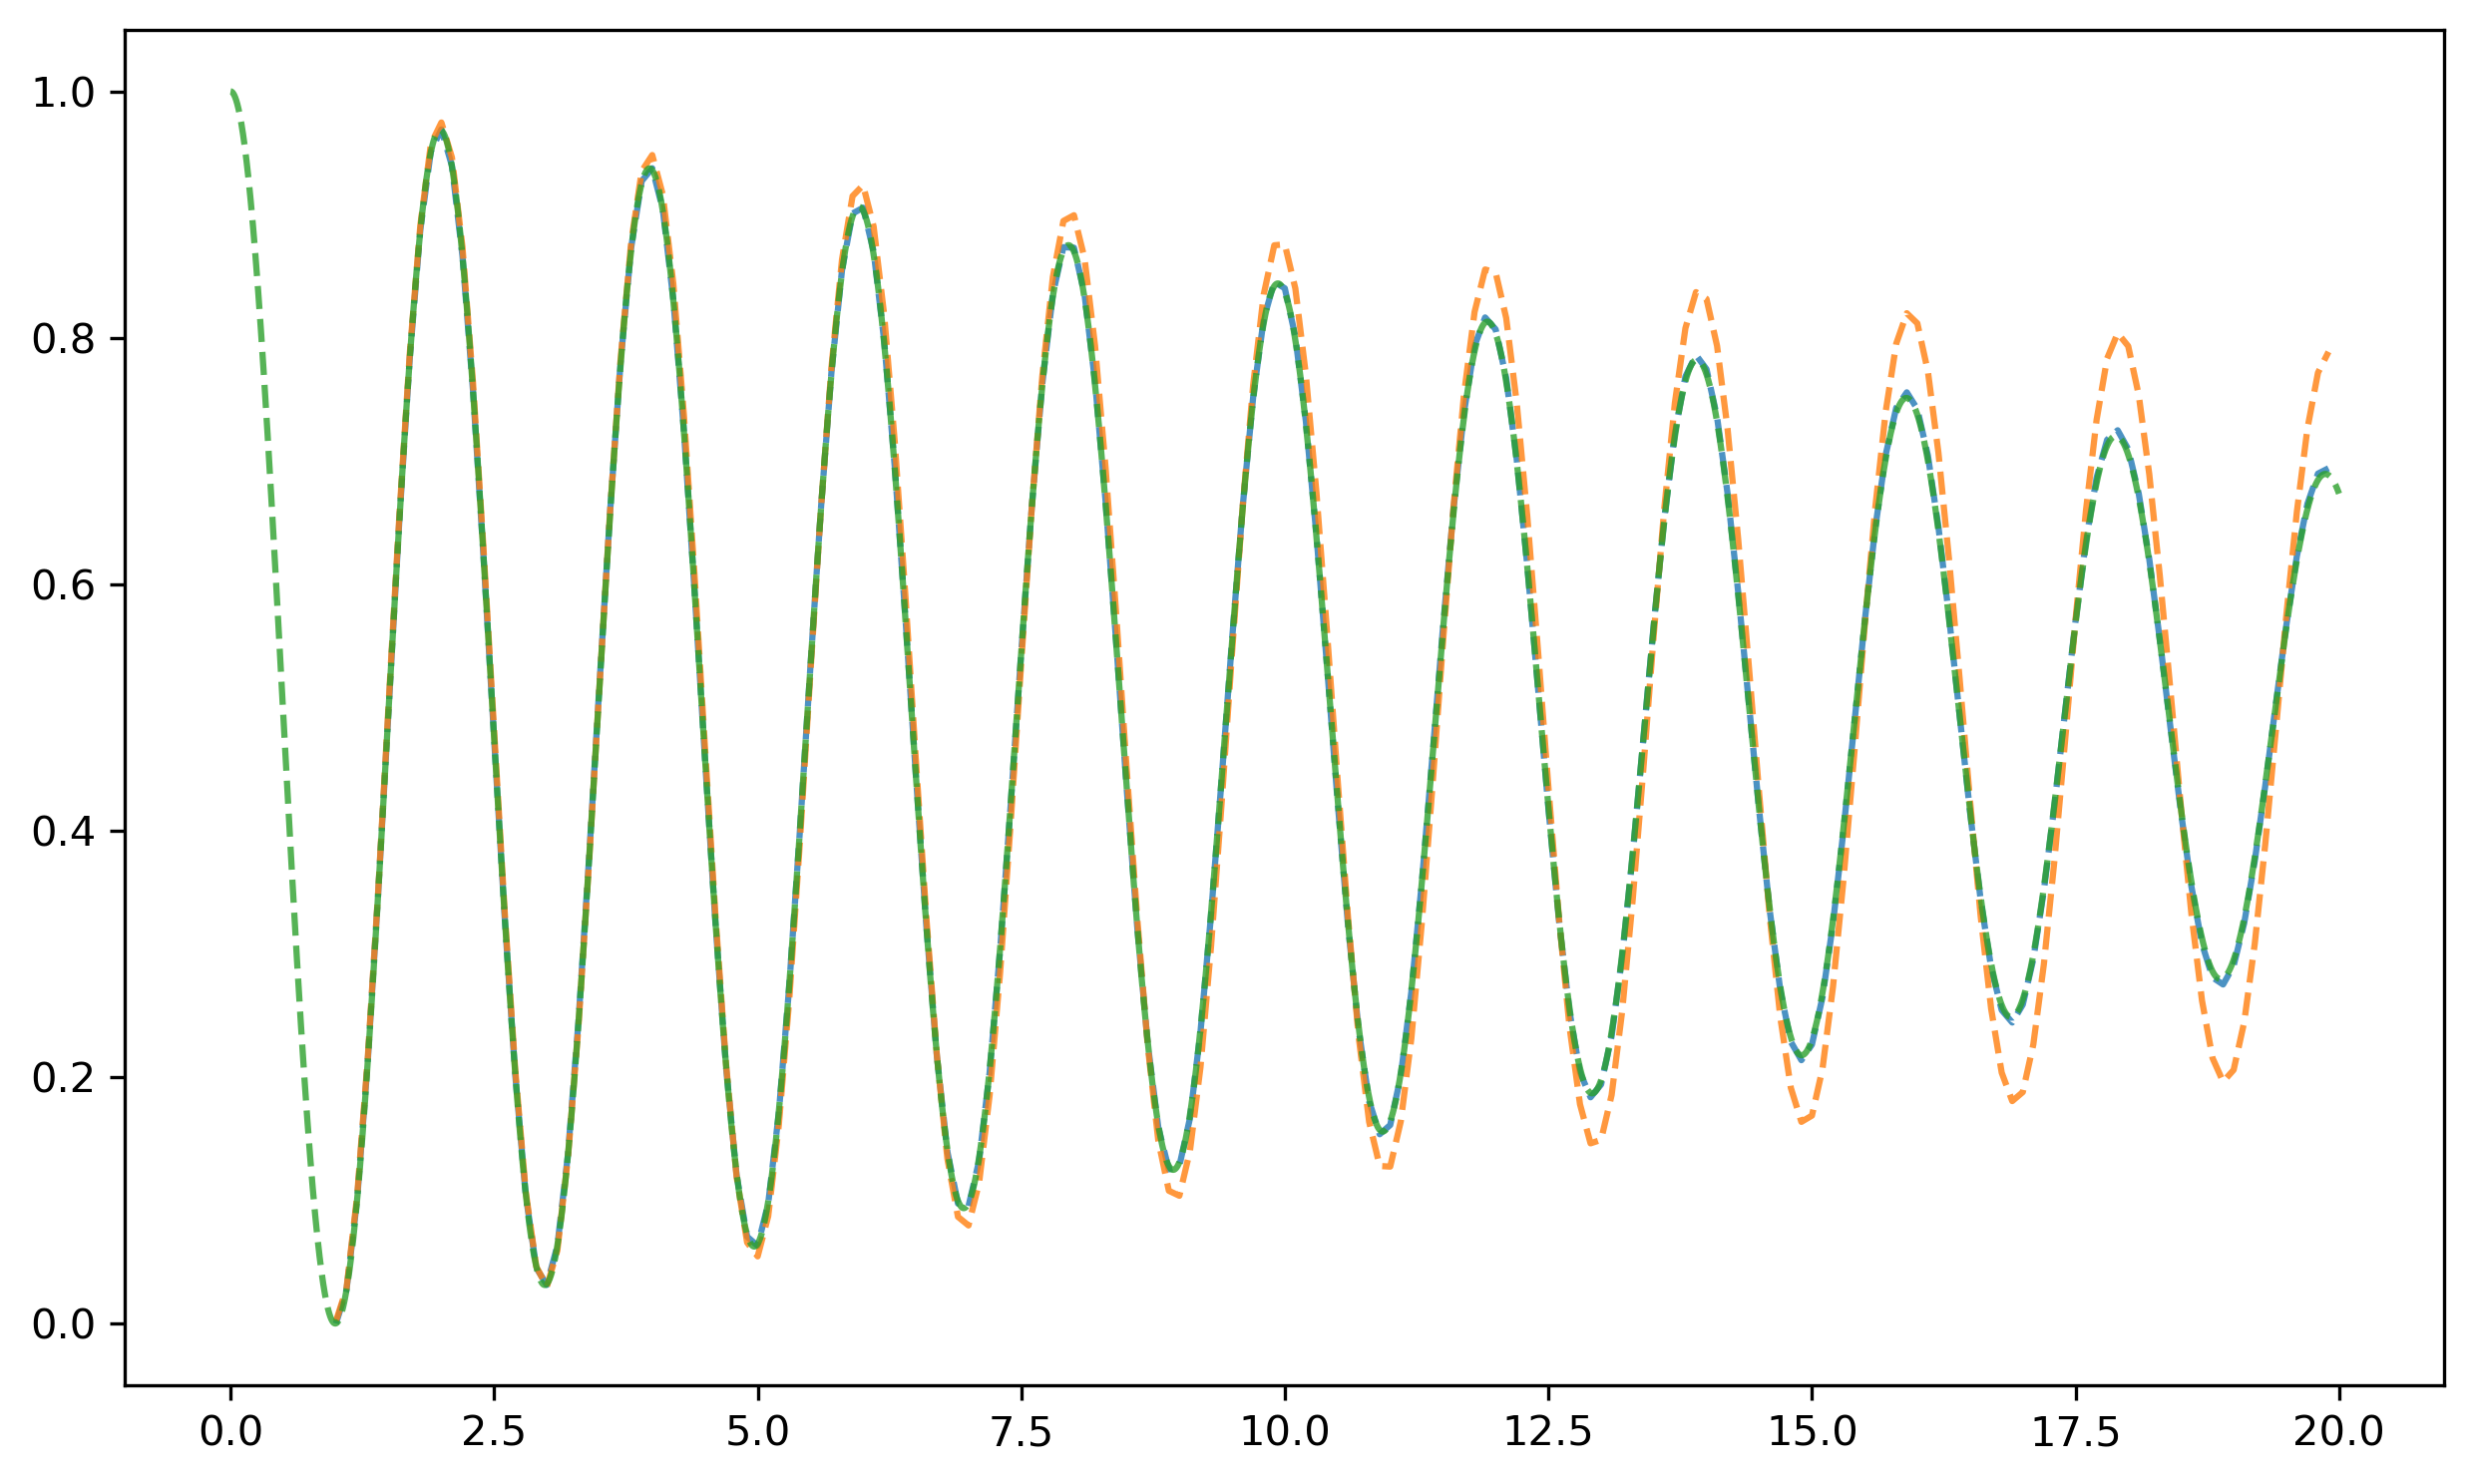

In [49]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t, y[:,0].cpu().numpy(), '--', alpha=0.8)
plt.plot(t_total, y_pred_total[:,0], '--', alpha=0.8)
plt.plot(t_shoo, y_shoo_new[:,0], '--', alpha=0.8)

# plt.axvline(t[100], linestyle='--', color='r')
# plt.xlim([0, 20])
# plt.ylim([-0.1,1.1])
plt.show()

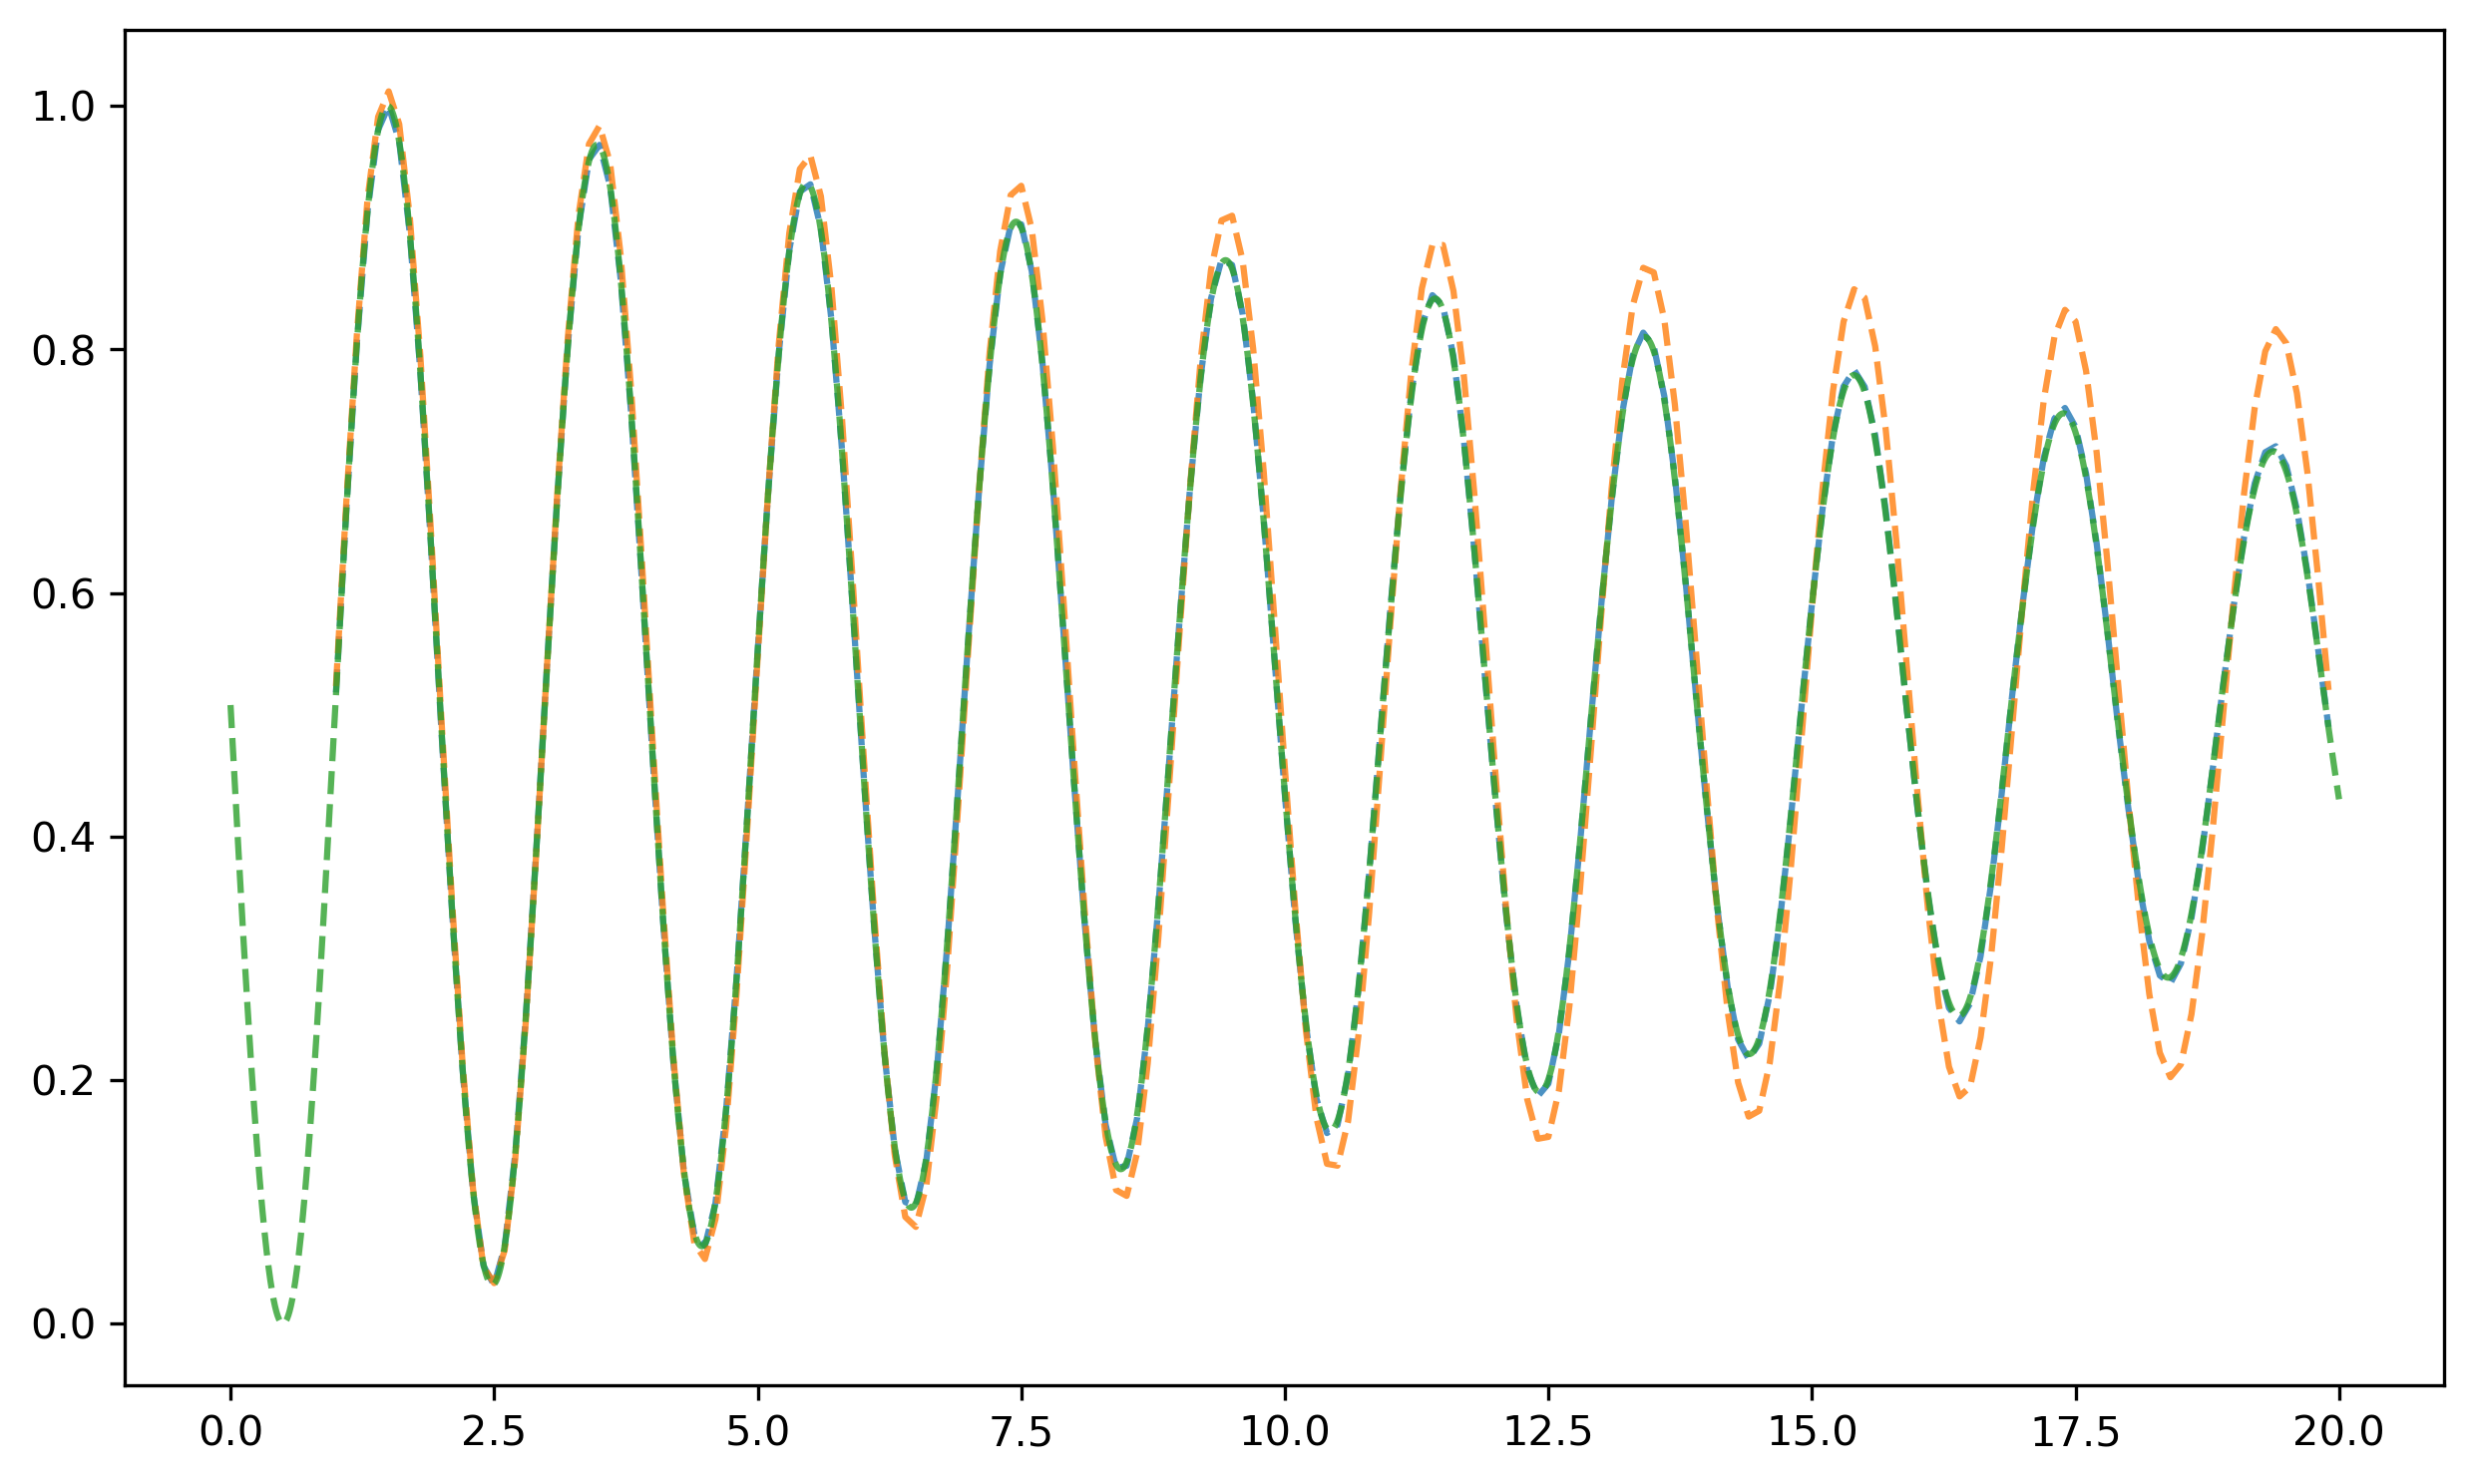

In [50]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t, y[:,1].cpu().numpy(), '--', alpha=0.8)
plt.plot(t_total, y_pred_total[:,1], '--', alpha=0.8)
plt.plot(t_shoo, y_shoo_new[:,1], '--', alpha=0.8)

# plt.axvline(t[100], linestyle='--', color='r')
# plt.xlim([0, 20])
# plt.ylim([-0.1,1.1])
plt.show()

In [51]:
def energy(data):
    if type(data) == torch.Tensor:
        data = data.detach().numpy()
    data = sc.inverse_transform(data)
    return (0.5 * 10 * data[:,0]**2 + 0.5 * data[:,1]**2) / 2000

In [52]:
E_target = energy(y)
E_pred = energy(y_pred_total)
E_origin = energy(y_shoo_new)

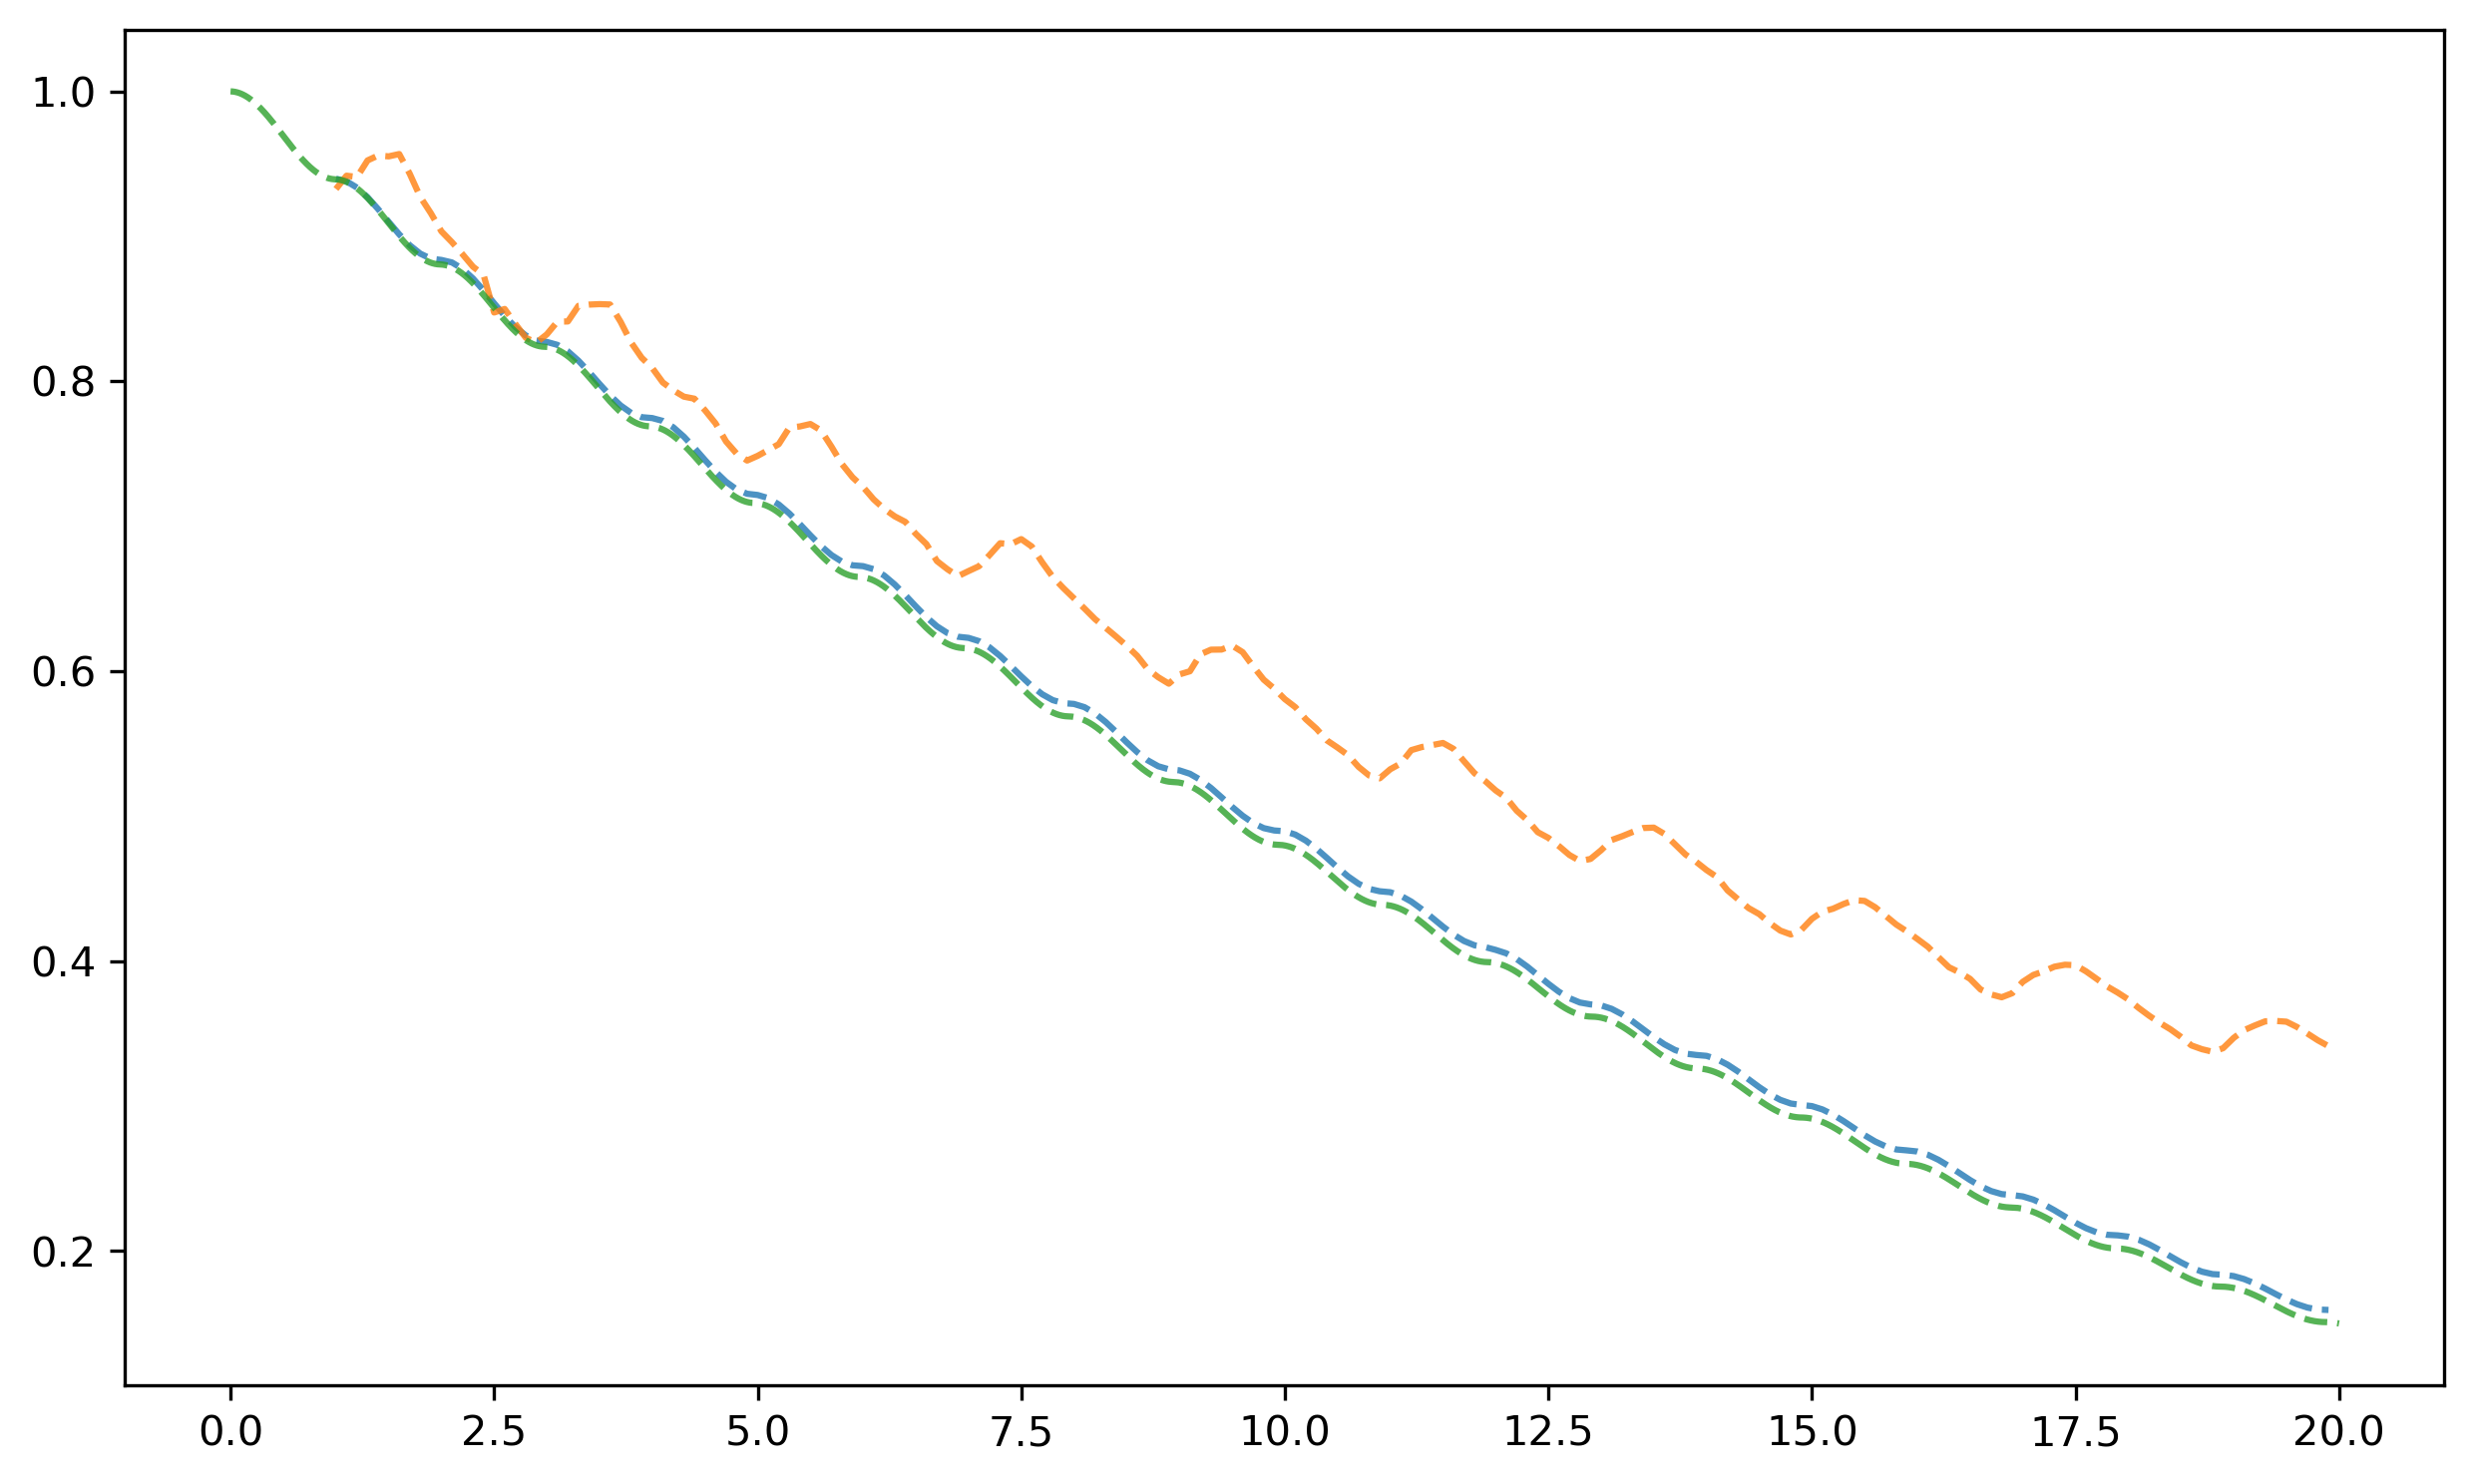

In [53]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t, E_target, '--', alpha=0.8)
plt.plot(t_total, E_pred, '--', alpha=0.8)
plt.plot(t_shoo, E_origin, '--', alpha=0.8)

# plt.axvline(t[100], linestyle='--', color='r')
# plt.xlim([0, 20])
# plt.ylim([-0.1,1.1])
plt.show()